In [ ]:
import tensorflow as tf
x = tf.Variable(3,name='x')
y = tf.Variable(4,name='y')
f = x*x*y + y + 2 
#these actually doesnot do anything
#this simply creates a computational graph and nothing is being
#initialized



Put it into a Session

In [ ]:
sess = tf.Session()
sess.run(x.initializer)#put into a CPU and initialize a variable
sess.run(y.initializer)
result = sess.run(f)#evaluate a expression
print(result)
sess.close()



In [ ]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

In [ ]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()#initialize all the variables
    result = f.eval()
print(result)

Managing graph

In [ ]:

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()#any node is automatically added to the default graph

In [ ]:
graph = tf.Graph()
with graph.as_default():#To manage some independent graph, you temporiarily 
    #make it a default graph
    x2 = tf.Variable(2)

x2.graph is graph
x2.graph is tf.get_default_graph()

LifeCycle of a Node value

In [ ]:
#While evaluating a node, tnsorflow automatically determines
#which value you should evaluate first if it depends on something else
#

w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15
    
    #this evaluate x and w twice as they dont reuse those values
    #to save resources, you must ask tf to eval t and z in one graph run
    with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

Linear Regression with Tensor Flow

In [ ]:
import numpy as np
from sklearn.datasets import fetch_california_housing


housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

Gradient Descent

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing


housing = fetch_california_housing()

scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Autodiff is a much more easier way to compute the gradient since it helps you find the best parameter

In [ ]:
gradients = tf.gradients(mse, [theta])[0]

Optimizer can be used to replace the traditional method of gradient descent

In [ ]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

Momentum optimizer sometimes converge much more faster than the normal optimizer

In [ ]:

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

# Feeding batches of training data

The placeholder allow us to deplay the input parameter and feed them into the model continously later on

In [ ]:

A = tf.placeholder(tf.float32,shape=(None,3))
#A must be 2 dimensional and must have 3 columns
#None means it can be any number of rows
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A:[[1,2,3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)

Now we want to implement mini-batch gradient descent and we only need to change a bit of code snips

In [ ]:
init = tf.global_variables_initializer()
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [ ]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = scaled_housing_data_plus_bias[indices] #fetch part of the data
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})#feed to out model

    best_theta = theta.eval()

# Saving and Resotring Model

* you want to keep the parameters to disk so you can come back to it whenever you want
* build checkpoints during training, when your computer crashes, you can go back to where you left off, instead of starting again

simply create a **saver** node at the end of the construction phase, then call **save()** in the execution phase whenever yo uwant to save a model, passing it the session and path of the checkpoint file 

In [ ]:
n_epochs = 1000                                                                       # not shown in the book
learning_rate = 0.01                                                                  # not shown

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # not shown
# not shown
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                              
            save_path = saver.save(sess, "/tmp/my_model.ckpt")#checkpoint every 100 epochs
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

Restoring a model is even easier, you create saver at the end of the construction phase, **at the begining of the execution phase, call restore() rather than initlizating variables**

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() # not shown in the boo



By default, Saver save and restore variables under their own name, you can also specify which variable to save or store and their name.

* the example below Saver will save only the theta variable under the name "weights"

In [ ]:
saver = tf.train.Saver({"weights": theta})

By default the saver also saves the graph structure itself in a second file with the extension .meta. You can use the function tf.train.import_meta_graph() to restore the graph structure. This function loads the graph into the default graph and returns a Saver that can then be used to restore the graph state (i.e., the variable values)

In [ ]:
saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")  # this loads the graph structure
theta = tf.get_default_graph().get_tensor_by_name("theta:0") # not shown in the book

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")  # this restores the graph's state
    best_theta_restored = theta.eval() # not shown in the book

# Visualizing the graph

Using **TensorBoard** to visualize the stats

* write the training data and error to a log directory that TensorBoard can read
* need separate directory everytime when your program runs(otherwise it merges all data)
* include a timestamp in the log directory name showed below

In [ ]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = 'tf_logs'
logdir = "{}/run-{}/".format(root_logdir, now)
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing


housing = fetch_california_housing()

scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [ ]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()


In [ ]:
#This creates a node in the graph that will evaluate the MSE and write it to a binary log string  summary
mse_summary = tf.summary.scalar("MSE",mse)
#A file write that will write summaries to logfiles in log directory
#first param indicates the path of the log directory, second(optional) is the graph u want to visualize
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())

In [ ]:

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [ ]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = scaled_housing_data_plus_bias[indices] #fetch part of the data
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch
with tf.Session() as sess:                                                        # not shown in the book
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch,y_batch = fetch_batch(epoch,batch_index,batch_size)
            if batch_index % 10 == 0:#evaluate mse_summary at every 10 mini-batches
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best = theta.eval()
file_writer.close()    

In [ ]:
best

# Name scopes

Graph can be cluttered with thousands of nodes, name scopes can group related nodes
Lets define mse and error under the name scope "loss"

In [ ]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error),name = "mse")
print(error.op.name)

# Modularity

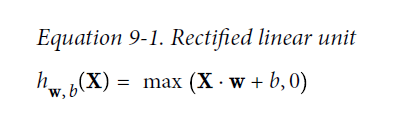

This way is too much hard coding and much better to done it through function

In [ ]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z1, 0., name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add(relu1, relu2, name="output")

Better approach

In [ ]:
def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

* Keep in mind that Tensorflow will handle whether there is a naming collison, it will append a "_index#" to make it unique
* So first RelU contains "weights", "bias", second will be "weight_1" ...
* Its always good to use a name scope to make it much more cleaner

In [ ]:
def relu(X):
    with tf.name_scope("relu"):
        #....

# Sharing Variables


Set the shared variable as an attribute of the relu() function upon the first call

* Use get_variable() function to create the shared variable if it does not exist yet or reuse it if it is already exist

In [ ]:
def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, relu.threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

* The following code creates a variable named relu/threshold as a scalar

In [ ]:
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

* **if the variable has already been created by an earlier call to get_variable, exception is raised**

* Reusing variable needs to be stated explicitly by setting "reuse" attribute to **True**

* The following code would still raise an exception  if it **Doen not exist** or **its not created using get_variable()**

In [ ]:

with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

## Keep in mind that once reuse is set to be true, it can't be set back to false within the block. Other variables scopes inside this one will automatically inherit reuse = True

Instead, you can always reuse variable by calling the scope.reuse_variables() method

In [ ]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [ ]:
def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")


with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

Variable created using get_varaible always have a prefix of the name of the variable_scope. suffix will be added if there is name scope collison. **In this case w,b,z(varaibles created with tf.Variable) and the varaible_scope will have a unique name with suffix** 

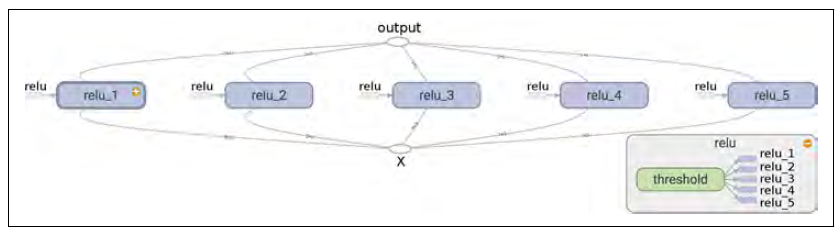

now let's make this modification where the threhold is created during the first call of RelU and reuse it during the subsequent call, no need to worry about name_scope or sharing. Make sure to set reuse to be False in the first call, and True for the rest

In [ ]:
def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

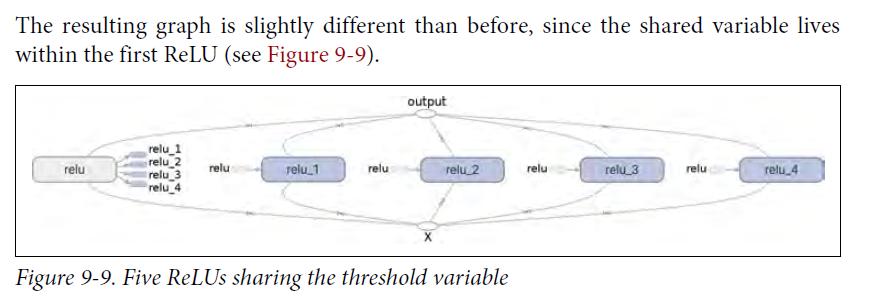

# Exercise

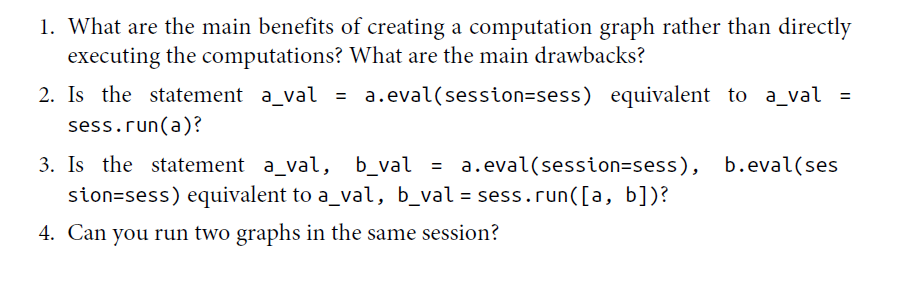

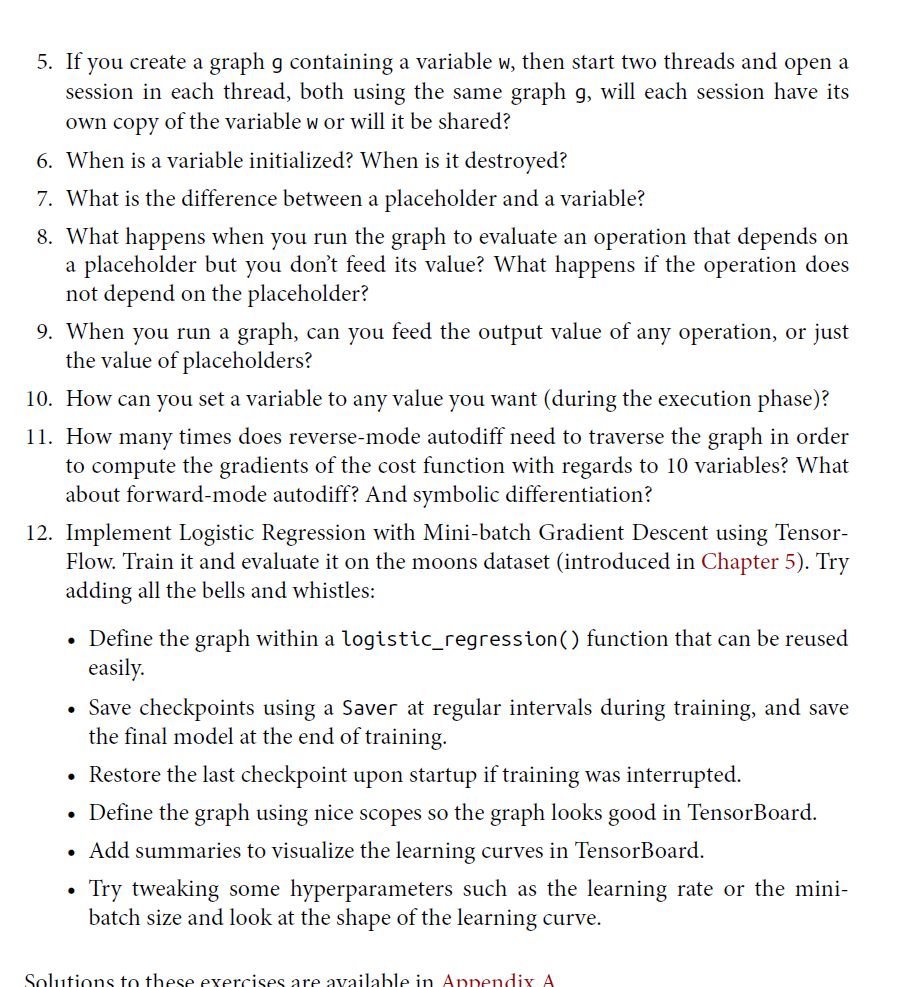

1.1. Main benefits and drawbacks of creating a computation graph rather than
directly executing the computations:
• Main benefits:
—TensorFlow can automatically compute the gradients for you (using
reverse-mode autodiff).
—TensorFlow can take care of running the operations in parallel in different
threads.
—It makes it easier to run the same model across different devices.
—It simplifies introspection—for example, to view the model in TensorBoard.
• Main drawbacks:
—It makes the learning curve steeper.
—It makes step-by-step debugging harder.


2. Yes, the statement a_val = a.eval(session=sess) is indeed equivalent to a_val
= sess.run(a).

3. No, the statement a_val, b_val = a.eval(session=sess), b.eval(ses
sion=sess) is not equivalent to a_val, b_val = sess.run([a, b]). Indeed, the
first statement runs the graph twice (once to compute a, once to compute b),
while the second statement runs the graph only once. If any of these operations
(or the ops they depend on) have side effects (e.g., a variable is modified, an item
is inserted in a queue, or a reader reads a file), then the effects will be different. If
they don’t have side effects, both statements will return the same result, but the
second statement will be faster than the first.

4. No, you cannot run two graphs in the same session. You would have to merge the
graphs into a single graph first.

5. In local TensorFlow, sessions manage variable values, so if you create a graph g
containing a variable w, then start two threads and open a local session in each
thread, both using the same graph g, then each session will have its own copy of
the variable w. However, in distributed TensorFlow, variable values are stored in
containers managed by the cluster, so if both sessions connect to the same cluster
and use the same container, then they will share the same variable value for w.

6. A variable is initialized when you call its initializer, and it is destroyed when the
session ends. In distributed TensorFlow, variables live in containers on the cluster,
so closing a session will not destroy the variable. To destroy a variable, you
need to clear its container.

7. Variables and placeholders are extremely different, but beginners often confuse
them:
• A variable is an operation that holds a value. If you run the variable, it returns
that value. Before you can run it, you need to initialize it. You can change the
variable’s value (for example, by using an assignment operation). It is stateful:
the variable keeps the same value upon successive runs of the graph. It is typically
used to hold model parameters but also for other purposes (e.g., to count
the global training step).
• Placeholders technically don’t do much: they just hold information about the
type and shape of the tensor they represent, but they have no value. In fact, if you try to evaluate an operation that depends on a placeholder, you must feed
TensorFlow the value of the placeholder (using the feed_dict argument) or
else you will get an exception. Placeholders are typically used to feed training
or test data to TensorFlow during the execution phase. They are also useful to
pass a value to an assignment node, to change the value of a variable (e.g.,
model weights).

8. If you run the graph to evaluate an operation that depends on a placeholder but
you don’t feed its value, you get an exception. If the operation does not depend
on the placeholder, then no exception is raised.

9. any value

10. use a placholder to ask for values and assign the place holder to the new value

In [ ]:
import tensorflow as tf
x = tf.Variable(tf.random_uniform(shape=(), minval=0.0, maxval=1.0))
x_new_val = tf.placeholder(shape=(), dtype=tf.float32)
x_assign = tf.assign(x, x_new_val)
with tf.Session():
    x.initializer.run() # random number is sampled *now*
    print(x.eval()) # 0.646157 (some random number)
    x_assign.eval(feed_dict={x_new_val: 5.0})
    print(x.eval()) # 5.0

11. 11. Reverse-mode autodiff (implemented by TensorFlow) needs to traverse the graph
only twice in order to compute the gradients of the cost function with regards to
any number of variables. On the other hand, forward-mode autodiff would need
to run once for each variable (so 10 times if we want the gradients with regards to
10 different variables). As for symbolic differentiation, it would build a different
graph to compute the gradients, so it would not traverse the original graph at all
(except when building the new gradients graph). A highly optimized symbolic
differentiation system could potentially run the new gradients graph only once to
compute the gradients with regards to all variables, but that new graph may be
horribly complex and inefficient compared to the original graph



* Reverse-mode autodiff n(outputs) + 1, Forward-mode autodiff n(inputs), Symbolic(unknown)

## 12

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
m = 1000
X_moons,y_moons = make_moons(m,noise = 0.1,random_state = 42)
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0],X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
from sklearn.model_selection import train_test_split
x_moons_with_bias = np.c_[np.ones((m,1)),X_moons]
y_moons_column_vector = y_moons.reshape(-1,1)
X_train,X_test,y_train,y_test = train_test_split(x_moons_with_bias,y_moons_column_vector,test_size = 0.2)

In [3]:
def random_batch(X_train,y_train,batch_size):
    index = np.random.randint(0,len(X_train),batch_size)
    X_batch = X_train[index]
    y_batch = y_train[index]
    return X_batch,y_batch
    

print(random_batch(X_train,y_train,5))

(array([[ 1.        ,  1.08423868, -0.65769808],
       [ 1.        , -0.02017137,  0.30454828],
       [ 1.        ,  1.73370971, -0.17880096],
       [ 1.        ,  0.5851179 ,  0.7737684 ],
       [ 1.        ,  0.88781515,  0.19596429]]), array([[1],
       [1],
       [1],
       [0],
       [0]], dtype=int64))


Now we can start build the logistic regression model

In [4]:
import tensorflow as tf
n_input = 2

In [5]:
X = tf.placeholder(tf.float32,shape=(None,n_input + 1),name='X')
y= tf.placeholder(tf.float32,shape=(None,1),name='y')
theta = tf.Variable(tf.random_uniform([n_input+1,1],-1.0,1.0,seed=42),name='theta')
logits = tf.matmul(X,theta,name='logits')
y_proba = 1/(1+tf.exp(-logits))
#y_proba= tf.sigmoid(logits)

Instructions for updating:
Colocations handled automatically by placer.


$J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} \log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) \log\left(1 - \hat{p}^{(i)}\right)\right]}$

the first logist form is the vectorized form, the p^ here represent the sigmoid form probability

In [6]:
epsilon = 1e-7  # to avoid an overflow when computing the log
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1-y_proba + epsilon))
#loss = tf.losses.log_loss(y,y_proba)
learning_rate = 0.1
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

Exectuion phase

In [7]:
init = tf.global_variables_initializer()
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch,y_batch = random_batch(X_train,y_train,batch_size)
            sess.run(training_op, feed_dict={X: X_batch,y:y_batch})
        loss_val = loss.eval({X: X_test,y: y_test})# we evaluate this for every 100 trainning
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

#estimated probability#    
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.6923367
Epoch: 100 	Loss: 0.20546295
Epoch: 200 	Loss: 0.20305844
Epoch: 300 	Loss: 0.20236991
Epoch: 400 	Loss: 0.20158476
Epoch: 500 	Loss: 0.20199926
Epoch: 600 	Loss: 0.20195533
Epoch: 700 	Loss: 0.20346518
Epoch: 800 	Loss: 0.20225585
Epoch: 900 	Loss: 0.20146427


In [8]:

y_proba_val[:5]
y_pred = (y_proba_val >=0.5)


In [42]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score, recall_score,f1
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)
precision_score(y_test, y_pred)
recall_score(y_test, y_pred)


[[95 12]
 [ 9 84]]
0.895


0.9032258064516129

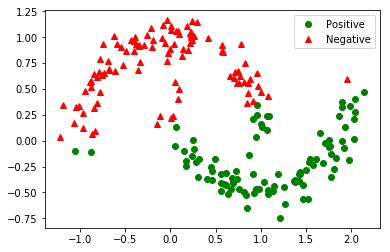

In [9]:

y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

we will add 4 more features to the inputs: ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ and ${x_2}^3$. This was not part of the exercise, but it will demonstrate how adding features can improve the model. We will do this manually, but you could also add them using sklearn.preprocessing.PolynomialFeatures.

In [25]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 3)
X_train_enhanced = poly.fit_transform(X_train)
X_test_enhanced = poly.fit_transform(X_test)


In [ ]:
def logistic_regression(X,y,initializer=None,seed=42,learning_rate = 0.01):
    n_input_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic regression"):
        with tf.name_scope("model"):
            if initializer==None:
                initializer = tf.random_uniform([n_input_include_bias + 1, 1],-1.0,1.0,seed=seed)
    
            theta = tf.Variable(initializer,name='theta')
            logits = tf.matmul(X,theta,name='logits')
            y_proba = 1/(1+tf.exp(-logits))
        with tf.name_scope("train"):
            epsilon = 1e-7  # to avoid an overflow when computing the log
            loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1-y_proba + epsilon))
            learning_rate = 0.1
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init")
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
        return y_proba, loss, training_op, loss_summary, init, saver
            
    

In [ ]:
from datetime import datetime
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)


In [ ]:
n_inputs = 19
logdir = log_dir("logreg")
X = tf.placeholder(tf.float32,shape=(None,n_inputs+1),name='X')
y = tf.placeholder(tf.float32,shape=(None,1),name='y')
y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())

At last we can train the model! We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved. In this example we just save the epoch number to a separate file, but in chapter 11 we will see how to store the training step directly as part of the model, using a non-trainable variable called global_step that we pass to the optimizer's minimize() method.

You can try interrupting training to verify that it does indeed restore the last checkpoint when you start it again.

In [ ]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Now you can play around with the hyperparameters (e.g. the batch_size or the learning_rate) and run training again and again, comparing the learning curves. You can even automate this process by implementing grid search or randomized search. Below is a simple implementation of a randomized search on both the batch size and the learning rate. For the sake of simplicity, the checkpoint mechanism was removed.

In [ ]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)#randomized search

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))